In [1]:
# Purpose: Preparing the pre-industrial spin-up forcing datasets. Only the 
#          SAT, RLDS and HUSS files change by -0.133°C, -0.7 W m**-2 and
#          relative humidity staying constant
#          -> the remaining variables are from the RDF (repeat decade forcing)
#             over 1962-01-01 to 1971-31-12
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 17. 02. 2022      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps                                                                   
import os.path # to check if file exists
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.mpl.ticker as cticker
from matplotlib import ticker
from netCDF4 import Dataset    # Note: python is case-sensitive!

import cartopy.feature as cfeature

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

from dask.distributed import Client
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33255,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:39823,Total threads: 4
Dashboard: /proxy/46649/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:32967,


### First, create the folders and subfolders in bash where the forcing files will get stored. Only then will the script work properly
> cd /g/data/e14/mv7494/ # change into directory where you will save your pre-industrial forcing files \
> mkdir Pre-industrial_JRA55-do-1-3 # create a folder \
> cd Pre-industrial_JRA55-do-1-3 \
> mkdir friver huss prra prsn psl rlds rsds tas uas vas

The relative humidity is a function of the temperature:

$$e = \frac{qp}{0.622+0.378q}$$
$$e_s(T)=e_s(T_0) \times \exp{ \frac{L}{R_w} \left( \frac{1}{T_0}-\frac{1}{T} \right) } $$

$$q_{new} = \frac{e \times (0.622)}{\left( p\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }- 0.378e \right) } $$  

So what I need are the following files: relative humidity_RDF, pressure_RDF, temperature_RDF and temperature_Pre-industrial

In [2]:
%%time
forcing = '1-3'
             #   SAT (°C), RLDS (W m**-1)
pi_offsets = [     -0.133,          -0.7]

# ---- ATTENTION! ---- #
# you will need to change these two so they point towards the folder where you would like to save your data and towards the JRA55-do files on your cluster
save_folder   = '/g/data/e14/mv7494/'
base          = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/' # this string points to the folder which has all the JRA55-do forcing
# ---- ATTENTION! ---- #

experiment    = 'Pre-industrial_JRA55-do-1-3/'
fname         = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_'            # filenames of the JRA55-do forcing
version       = 'gn/v20180412/'                                                     # version of the forcing
hrPt_timestep = ['01010000','12312230']                                             # time steps for the different fields; e.g., those in the hrPt folder have 01010000-12312230 in their naming
hr_timestep   = ['01010130','01010000']
day_timestep  = ['0101','0101']
domain        = 'atmos/'
var           = ['tas','huss','rlds', 'psl']                                         # these are the three variables I need to change the TAS, HUSS and RDLS files to pre-industrial
print('#########################################')    
print('        '+experiment+'        ')
print('#########################################')
                                              
a = np.linspace(1962,1972,11) # the repeat decade period

for i in range(3):                   # loop over the JRA55 variables that I need to change: tas, huss and rlds
    for year in range(0,10):         # loop over the first ten years, i.e., the RDF period (0, 10)
        year_a = str(int(a[year]))
        year_aa = str(int(a[year+1]))
        startTime = datetime.now()   # start clock     

        print('Year ' + year_a + ' & ' + var[i])   # print year 


        # get correct resolution of forcing field, either '3hr', '3hrPt' or 'day'
        if var[i] in ['rsds','rlds','prra','prsn']:
            res = '3hr/'
        elif var[i] in ['psl','tas','huss','uas','vas']:
            res = '3hrPt/'
        else:
            res = 'day/'

        # load in data for climatological repeat decade forcing (RDF)
        ds1 = xr.open_mfdataset(base + domain + res + var[i] + '/' + version + var[i] + fname + year_a + '*',combine = 'by_coords', 
                                chunks = {'time': '300MB'},decode_times = True) # open dataset


        # -------------------------------------------------------------------------------------------------------------------------- #
        # pre-industrial offset adjustment                                                                                           #
        # -------------------------------------------------------------------------------------------------------------------------- #
        if var[i] == 'tas':
            ds1['tas'] = ds1.tas + pi_offsets[0] # adjust with pre-industrial offset: substract 0.133 °C from the surface air temperature field

        if var[i] == 'rlds':
            ds1['rlds'] = ds1.rlds + pi_offsets[1] # adjust with pre-industrial offset: subtract 0.7 W m**-2 from the downward longwave radiation field

        # adjusting the relative humidity is a bit more complicating because we need to do the calculations written in the cell above
        if var[i] == 'huss':
            # for the constant relative humidity calculation, I need RDF specific humidity, RDF sea level pressure as well as RDF and PI surface air temperature 
            huss_rdf = xr.open_mfdataset(base + domain + res + var[1] + '/' + version + var[1] + fname + year_a + '*',combine = 'by_coords', 
                                         chunks = {'time': '300MB'},decode_times = True).huss # open dataset
            psl_rdf = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',
                                        combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset
            
            tas_pi = xr.open_mfdataset(save_folder + experiment + var[0] + '/' + var[0] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                                       combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
            tas_rdf = xr.open_mfdataset(base + domain + res + var[0] + '/' + version + var[0] + fname + year_a + '*',
                                        combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset

            # copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
            e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf)
            e_s_0 = 6.11*100 #Pa
            T_0 = 273.15 #K

            L = 2.5*10**6 #J/kg
            R_w = 462.52#J/kgK

            ds2 = e_rdf*0.622/(psl_rdf*np.exp(L/R_w *(1/tas_pi - 1/tas_rdf))-0.378*e_rdf)
            # load in initial file to have the correct data structure
            ds1 = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',
                                    combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True) # open dataset
            ds1['huss'] = ds2 # overwrite the data with the new calculated relative humidity field

        # -------------------------------------------------------------------------------------------------------------------------- #
        # saving the fields as .nc files                                                                                             #
        # -------------------------------------------------------------------------------------------------------------------------- #
        # different file names depending on the variables
        if var[i] in ['uas','vas','tas','psl','huss']:
            # construct filename for output file, e.g.
            # filename = '/g/data/e14/mv7494/HeatDist_input/EXP_tropics_JRA55-do-1-3//uas/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_197201010000-12312230.nc'
            filename = save_folder + experiment + var[i] + '/' + var[i] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc'
            if os.path.isfile(filename) == True: # check if file already exists, if yes then I can skip that iteration which speeds up my script
                continue                
            else: 
                ds1.to_netcdf(filename) # if file not yet exists, save array to netcdf file
        elif var[i] in ['prra','prsn','rlds','rsds']:
            filename = save_folder + '/' + experiment + var[i] + '/' + var[i] + fname + year_a + hr_timestep[0] + '-' + year_aa + hr_timestep[1] + '.nc'
            if os.path.isfile(filename) == True:
                continue
            else: 
                ds1.to_netcdf(filename)
        elif var[i] == 'friver':
            if forcing == '1-3':
                filename = save_folder + experiment + var[i] + '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_aa + day_timestep[1] + '.nc'
            else:
                filename = save_folder + experiment + var[i] + '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_a + day_timestep[1] + '.nc'

            if os.path.isfile(filename) == True:
                continue
            else: 
                ds1.to_netcdf(filename)

        print(datetime.now() - startTime) # end time of script
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')    
    # Note: Saving one month of data takes 18 seconds
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    print('#########################################')    
    print('#           Variable finished           #')
    print('#########################################')

### Checking the TAS, RSDS and HUSS files if all calculations correct

#########################################
        Pre-industrial_JRA55-do-1-3/        
#########################################
Year 1962 & tas
Year 1963 & tas
Year 1964 & tas
Year 1965 & tas
Year 1966 & tas
Year 1967 & tas
Year 1968 & tas
Year 1969 & tas
Year 1970 & tas
Year 1971 & tas
#########################################
#           Variable finished           #
#########################################
Year 1962 & huss
Year 1963 & huss
Year 1964 & huss
Year 1965 & huss
Year 1966 & huss
Year 1967 & huss
Year 1968 & huss
Year 1969 & huss
Year 1970 & huss
Year 1971 & huss
#########################################
#           Variable finished           #
#########################################
Year 1962 & rlds
Year 1963 & rlds
Year 1964 & rlds
Year 1965 & rlds
Year 1966 & rlds
Year 1967 & rlds
Year 1968 & rlds
Year 1969 & rlds
Year 1970 & rlds
Year 1971 & rlds
#########################################
#           Variable finished           #
###################################

### Checking if offset in TAS is correct

In [3]:
input = '/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-3/'
tas_rdf = xr.open_mfdataset(base + domain + '3hrPt/' + var[0] + '/' + version + var[0] + fname + '1962*',
                                        combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas[0,:,:].load() # open dataset
tas_pi = xr.open_mfdataset(save_folder + experiment + var[0] + '/' + var[0] + fname + '1962*',
                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas[0,:,:].load()

(tas_rdf-tas_pi).mean(['lat','lon']).values # ok, all correct. The pre-industrial offset is 0.1329956 °C

array(0.1329956, dtype=float32)

### Checking if offset in RLDS is correct

In [4]:
rlds_rdf = xr.open_mfdataset(base + domain + '3hr/' + var[2] + '/' + version + var[2] + fname + '1962*',
                                        combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).rlds[0,:,:].load() # open dataset
rlds_pi = xr.open_mfdataset(save_folder + experiment + var[2] + '/' + var[2] + fname + '1962*',
                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).rlds[0,:,:].load()

(rlds_rdf-rlds_pi).mean(['lat','lon']).values # ok, all correct. The pre-industrial offset is 0.7 W m**-2

array(0.7000067, dtype=float32)

### Checking if relative humidity is constant

In [5]:
year_a ='1962'; res = '3hrPt/'
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/'
fname = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_' 
version = 'gn/v20180412/'
hrPt_timestep = ['01010000','12312230']; hr_timestep = ['01010130','01010000']; day_timestep = ['0101','0101']
var = ['uas','vas','tas','huss','rlds','rsds','prra','psl','prsn'] # only eight of the variables I used in my Msc

# load in all files required
huss_rdf = xr.open_mfdataset(base + 'atmos/' + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
huss_pi = xr.open_mfdataset(save_folder + experiment + var[3] + '/' + var[3] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
psl_rdf = xr.open_mfdataset(base + 'atmos/' + res + var[7] + '/' + version + var[7] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset

tas_pi = xr.open_mfdataset(save_folder + experiment + var[2] + '/' + var[2] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
tas_rdf = xr.open_mfdataset(base + 'atmos/' + res + var[2] + '/' + version + var[2] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset


In [6]:
# copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf) # water vapour pressure in RDF period
e_pi = huss_pi*psl_rdf/(0.622+0.378*huss_pi)      # water vapour pressure in PI (pre-industrial) period

e_s_0 = 6.11*100 #Pa
T_0 = 273.15 #K

L = 2.5*10**6 #J/kg
R_w = 462.52#J/kgK


e_s_rdf = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_rdf)) # saturation water vapour pressure in RDF period
e_s_pi = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_pi))   # saturation water vapour pressure in PI period

rel_humid_rdf = e_rdf/e_s_rdf # relative humidity in RDF period
rel_humid_pi = e_pi/e_s_pi    # relative humidity in PI period

Text(0.5, 1.0, 'Change in RH')

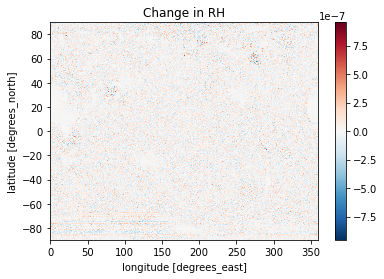

In [7]:
(rel_humid_rdf-rel_humid_pi).isel(time = 0).plot()
plt.title('Change in RH')

Note that the change in relative humidity is not exactly equal to zero because I have only used constants to 3 significant figures.

Text(0.5, 1.0, 'Relative error of change in RH')

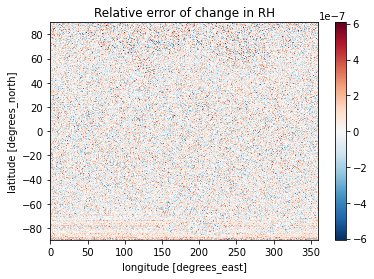

In [8]:
# relative error
((rel_humid_rdf-rel_humid_pi)/rel_humid_rdf).isel(time=2919).plot(); plt.title('Relative error of change in RH')

Great, the relative error is 1e-7 - so super small! All good.

### checking if the errors are normally distributed

(array([1.5000e+01, 2.9700e+02, 3.7490e+03, 2.3581e+04, 4.6656e+04,
        8.8653e+04, 3.2367e+04, 8.4810e+03, 9.6000e+02, 4.1000e+01]),
 array([-6.0722829e-07, -4.8958924e-07, -3.7195022e-07, -2.5431120e-07,
        -1.3667217e-07, -1.9033138e-08,  9.8605895e-08,  2.1624493e-07,
         3.3388395e-07,  4.5152299e-07,  5.6916201e-07], dtype=float32),
 <BarContainer object of 10 artists>)

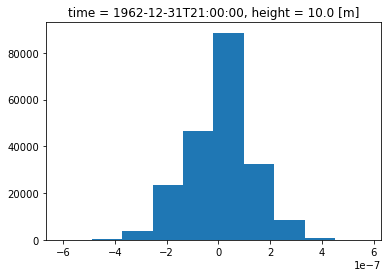

In [14]:
relative_errors = ((rel_humid_rdf-rel_humid_pi)/rel_humid_rdf).isel(time=2919)
relative_errors.plot.hist()

In [9]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #